# Fiber network active contraction

## Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace)
from dolfinx.fem.petsc import NonlinearProblem, apply_lifting, assemble_matrix, assemble_vector, set_bc
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunction, TrialFunction, grad, sqrt, derivative, dot, split, Jacobian,\
                  diag, as_vector,outer,cos,sin,variable,diag,action,diff,inner)

# basix finite elements (necessary for dolfinx v0.8.0)
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.INFO)

## Import mesh

In [2]:
mesh_folder="example_files/meshes/"
mesh_filename="microtissue_mesh.xdmf"
# mesh_filename="250test_normLen_mean0.3_sd0.05_randOrien.xdmf"

with XDMFFile(MPI.COMM_WORLD, mesh_folder+mesh_filename, "r") as xdmf:
    domain = xdmf.read_mesh(name="Grid")
domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)

x = ufl.SpatialCoordinate(domain)

[2025-05-15 18:20:35.123] [info] Opened HDF5 file with id "72057594037927936"
[2025-05-15 18:20:35.125] [info] Read topology data "Grid" at /Xdmf/Domain
[2025-05-15 18:20:35.126] [info] HDF5 Read data rate: 115.0099927483574 MB/s
[2025-05-15 18:20:35.126] [info] IO permuting cells
[2025-05-15 18:20:35.127] [info] Read geometry data "Grid" at /Xdmf/Domain
[2025-05-15 18:20:35.128] [info] HDF5 Read data rate: 107.3217761475326 MB/s
[2025-05-15 18:20:35.139] [info] Using partitioner with 19012 cell data
[2025-05-15 18:20:35.139] [info] Compute partition of cells across ranks
[2025-05-15 18:20:35.139] [info] Building mesh dual graph
[2025-05-15 18:20:35.139] [info] Build local part of mesh dual graph (mixed)
[2025-05-15 18:20:35.140] [info] Build nonlocal part of mesh dual graph
[2025-05-15 18:20:35.140] [info] Graph edges (local: 21076, non-local: 0)
[2025-05-15 18:20:35.140] [info] Compute graph partition using ParMETIS
[2025-05-15 18:20:35.141] [info] Computing communication graph edges

## Visualize the reference configuration

In [3]:
# import pyvista
# pyvista.set_jupyter_backend('html')
# from dolfinx.plot import vtk_mesh
# pyvista.start_xvfb()

# # initialize a plotter
# plotter = pyvista.Plotter()

# # Add the mesh.
# topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
# grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
# plotter.add_mesh(grid, show_edges=True) 

# labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
# plotter.add_axes(**labels)

# plotter.screenshot("example_files/images/mesh.png")

# from IPython.display import Image
# Image(filename="example_files/images/mesh.png") 

## User input or input from imaging

In [4]:
posts_pos = np.array([[0.100917431,0.110091743],[0.899082569,0.110091743],
                        [0.100917431,0.581039755],[0.899082569,0.577981651]])
post_shift = np.array([[1,1],[-1,1],[1,-1],[-1,-1]]) * 0.05
posts_pos+=post_shift
post_center_2,post_center_3,post_center_1,post_center_0 = posts_pos
post_radius = 0.1

## Function spaces

In [5]:
# Define the function space, both vectorial and scalar
Ue = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # for displacement. is shape the same as dim?
Te = element("Lagrange", domain.basix_cell(), 1) # for rotation
Th = mixed_element([Ue, Te]) # Taylor-Hood element
V = functionspace(domain, Th) # Total space for all DOFs

# Define the actual functions with the required DOFs
v = Function(V, name="Generalized displacement")
u, theta = split(v) # displacement u and rotation theta

# Define test functions
v_ = TestFunction(V)
u_, theta_ = split(v_)

# Define trial functions needed for automatic differentiation
dv = TrialFunction(V)

# Define the function space for the rotation?
VR = functionspace(domain, element("DG", domain.basix_cell(), 0, shape=(2, 2)))
V0 = functionspace(domain, element("DG", domain.basix_cell(), 0))

[2025-05-15 18:20:35.173] [info] Checking required entities per dimension
[2025-05-15 18:20:35.173] [info] Cell type: 0 dofmap: 9506x8
[2025-05-15 18:20:35.174] [info] Global index computation
[2025-05-15 18:20:35.174] [info] Got 2 index_maps
[2025-05-15 18:20:35.175] [info] Get global indices
[2025-05-15 18:20:35.176] [info] Checking required entities per dimension
[2025-05-15 18:20:35.176] [info] Cell type: 0 dofmap: 9506x1
[2025-05-15 18:20:35.177] [info] Global index computation
[2025-05-15 18:20:35.177] [info] Got 1 index_maps
[2025-05-15 18:20:35.177] [info] Get global indices
[2025-05-15 18:20:35.177] [info] Checking required entities per dimension
[2025-05-15 18:20:35.177] [info] Cell type: 0 dofmap: 9506x1
[2025-05-15 18:20:35.177] [info] Global index computation
[2025-05-15 18:20:35.178] [info] Got 1 index_maps
[2025-05-15 18:20:35.178] [info] Get global indices


## Identify the boundaries of the facets

In [6]:
def post_boundary(x,post_center,post_r,tol=1e-8):
    return np.sqrt( (x[0]-post_center[0])**2 + (x[1]-post_center[1])**2 ) - post_r <= tol

def post0_subdomain(x):
    return post_boundary(x,post_center_0,post_radius)

def post1_subdomain(x):
    return post_boundary(x,post_center_1,post_radius)

def post2_subdomain(x):
    return post_boundary(x,post_center_2,post_radius)

def post3_subdomain(x):
    return post_boundary(x,post_center_3,post_radius)

def all_cells(x):
    return x[0]>=0

boundaries = [(10,post0_subdomain),(11,post1_subdomain),(12,post2_subdomain),(13,post3_subdomain)]
# build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


# Locate the degrees of freedom associated with each pillar

p0_dofs_u1 = fem.locate_dofs_topological(V.sub(0).sub(0), facet_tags.dim, facet_tags.find(10))
p0_dofs_u2 = fem.locate_dofs_topological(V.sub(0).sub(1), facet_tags.dim, facet_tags.find(10))
p0_dofs_rot = fem.locate_dofs_topological(V.sub(1),facet_tags.dim,facet_tags.find(10))

p1_dofs_u1 = fem.locate_dofs_topological(V.sub(0).sub(0), facet_tags.dim, facet_tags.find(11))
p1_dofs_u2 = fem.locate_dofs_topological(V.sub(0).sub(1), facet_tags.dim, facet_tags.find(11))
p1_dofs_rot = fem.locate_dofs_topological(V.sub(1),facet_tags.dim,facet_tags.find(11))

p2_dofs_u1 = fem.locate_dofs_topological(V.sub(0).sub(0), facet_tags.dim, facet_tags.find(12))
p2_dofs_u2 = fem.locate_dofs_topological(V.sub(0).sub(1), facet_tags.dim, facet_tags.find(12))
p2_dofs_rot = fem.locate_dofs_topological(V.sub(1),facet_tags.dim,facet_tags.find(12))

p3_dofs_u1 = fem.locate_dofs_topological(V.sub(0).sub(0), facet_tags.dim, facet_tags.find(13))
p3_dofs_u2 = fem.locate_dofs_topological(V.sub(0).sub(1), facet_tags.dim, facet_tags.find(13))
p3_dofs_rot = fem.locate_dofs_topological(V.sub(1),facet_tags.dim,facet_tags.find(13))

# no Dirichlet boundary conditions
bcs = []

[2025-05-15 18:20:35.188] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.188] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.188] [info] Requesting connectivity (0, 0) - (0, 0)
[2025-05-15 18:20:35.188] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.189] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.189] [info] Requesting connectivity (0, 0) - (0, 0)
[2025-05-15 18:20:35.189] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.189] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.189] [info] Requesting connectivity (0, 0) - (0, 0)
[2025-05-15 18:20:35.189] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.190] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.190] [info] Requesting connectivity (0, 0) - (0, 0)


## Identify boundaries for the material subdomains

In [7]:
boundaries_material = [(100,post0_subdomain),(101,post1_subdomain),(102,post2_subdomain),(103,post3_subdomain)]
# build collections of cells on each subdomain and mark them appropriately.
pillar_cell_indices, pillar_cell_markers = [], [] # initalize empty collections of indices and markers.
cell_dim = domain.topology.dim # dimension of cells
for (marker, locator) in boundaries_material:
    cells = mesh.locate_entities(domain, cell_dim, locator) # an array of all the cells in a 
                                                         # given subdomain ("locator")
    pillar_cell_indices.append(cells)                         # add these cells to the collection.
    pillar_cell_markers.append(np.full_like(cells, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
pillar_cell_indices = np.hstack(pillar_cell_indices).astype(np.int32)
pillar_cell_markers = np.hstack(pillar_cell_markers).astype(np.int32)
sorted_pillar_cells = np.argsort(pillar_cell_indices)

# Take all cells indices, then remove the pillar cells indices to obtain fiber network indices
all_cells_indices = mesh.locate_entities(domain, cell_dim, all_cells)
fiber_network_cell_indices = np.array([ind for ind in all_cells_indices if ind not in pillar_cell_indices])
fiber_network_markers = np.full_like(fiber_network_cell_indices,0)

# Concatenate all cell indices and markers information
cell_indices = np.concatenate((pillar_cell_indices[sorted_pillar_cells],fiber_network_cell_indices))
cell_markers = np.concatenate((pillar_cell_markers[sorted_pillar_cells],fiber_network_markers))

# Add these marked facets as "mesh tags" for later use in BCs.
cell_tags = mesh.meshtags(domain, cell_dim, cell_indices, cell_markers)

[2025-05-15 18:20:35.202] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.203] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.203] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.203] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.203] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.203] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.203] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.204] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.204] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.204] [info] Requesting connectivity (1, 0) - (0, 0)


## Material parameters

In [8]:
fib_radius_network = 1e-2
E_network = 1e2
nu_network = 0.0

fib_radius_pillar = 1
E_pillar = 1e5
nu_pillar = 0.0

In [9]:
# mean_fib_len = 0.014033361281329213 # computed from the mesh generation code

# # kappa_tilde = br**2 / (4 * mean_fib_len**2)
# print(2*mean_fib_len*np.sqrt(1e-3))

## Define boundary and volume integration measure

In [10]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, subdomain_data=cell_tags, metadata={'quadrature_degree': 4})

#  Define facet normal
n = ufl.FacetNormal(domain)

## 2D beam kinematics

In [11]:
Jac = Jacobian(domain)
gdim = domain.geometry.dim
Jac = as_vector([Jac[i,0] for i in range(gdim)])
g01 = Jac/sqrt(dot(Jac,Jac))
g02 = as_vector([-g01[1], g01[0]])

r01 = outer(g01, as_vector([1, 0]))
r02 = outer(g02, as_vector([0, 1]))
R0 = r01 + r02

# Define functions for beams
def tgrad(u): # directional derivative wrt beam centerline in the initial configuration
    return dot(grad(u), g01)

def rotation_matrix(theta):
    return as_vector([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

Rot = rotation_matrix(theta)

# 2D beam kinematics
def gamma_value(t):
    return t

# Equations for contracting beams
gamma = Constant(domain, PETSc.ScalarType(1.0)) # growth stretch
lmbda = variable(dot(R0.T,dot(Rot.T,g01 + tgrad(u)))) # total stretch
alpha = variable(lmbda/gamma) # mechanical stretch
defo = variable(lmbda - as_vector([1,0])) # total_strain with rotationss
defo_e = variable(alpha - as_vector([1,0]))# mechanical strain with rotations
curv =  variable(tgrad(theta)) # curvature in initial configuration

# Equations for non-contracting beams
defo_nc = dot(R0.T, dot(Rot.T, g01+tgrad(u)) - g01)
curv_nc = tgrad(theta)

## Weak form

In [12]:
def get_strain_energy_active_contract(fib_rad,E_,nu_,curv_,defo_e_,kappa=1.0):

    S = np.pi * fib_rad**2
    I = np.pi * fib_rad**4 / 4
    G = E_/(2*(1+nu_)) # Shear Modulus

    # Beam stiffness
    ES = E_*S
    GS = G*S
    GS_2 = G*S*kappa
    EI = E_*I

    # Constitutive Equation
    C_N = diag(as_vector([ES, GS_2]))

    # Hyperelastic strain energy density function
    strain_energy = 0.5 * (dot(defo_e_, dot(C_N, defo_e_)) + EI*curv_**2)
    return strain_energy

def get_strain_energy(fib_rad,E_,nu_,curv_nc,defo_nc,kappa=1.0):

    S = np.pi * fib_rad**2
    I = np.pi * fib_rad**4 / 4
    G = E_/(2*(1+nu_)) # Shear Modulus

    # Beam stiffness
    ES = E_*S
    GS = G*S
    GS_2 = G*S*kappa
    GS_3 = G*S*kappa
    EI = E_*I

    # Constitutive equation
    C_N = diag(as_vector([ES, GS_2]))

    # Hyperelastic strain energy density function
    strain_energy = 0.5 * (dot(defo_nc, dot(C_N, defo_nc)) + (EI*curv_nc**2))

    return strain_energy


strain_energy_network = get_strain_energy_active_contract(fib_radius_network,E_network,nu_network,curv,defo_e)
strain_energy_pillars = get_strain_energy(fib_radius_pillar,E_pillar,nu_pillar,curv_nc,defo_nc)
total_strain_energy = strain_energy_network*gamma*dx(0) +\
                        strain_energy_pillars*dx(100) +\
                        strain_energy_pillars*dx(101) +\
                        strain_energy_pillars*dx(102) +\
                        strain_energy_pillars*dx(103)

# Applied Load:
F_max = Constant(domain,(0.0,0.0))
M_max = Constant(domain,0.0)

# Variational form
F_int = derivative(total_strain_energy,v,v_)
F_ext = (-M_max*theta_ + dot(F_max, u_))*ds
residual = F_int - F_ext
# tangent_form = derivative(residual, v, dv)

## Apply Robin boundary conditions

In [13]:
# class for Robin boundary
class RobinBC():
    def __init__(self,marker,r,s,constrain_rot=False):
        if constrain_rot is False:
            self.bc = r*inner(u-s,u_)*ds(marker) # apply Robin BC on the displacement
        elif constrain_rot is True:
            self.bc = r*inner(theta-s,theta_)*ds(marker) # apply Robin BC on the rotation

# Robin boundary parameters
r = 1
s = Constant(domain,(0.0,0.0))
s_theta = Constant(domain,0.0)

robin_bcs = [
    RobinBC(10,r,s),
    RobinBC(10,r,s_theta,constrain_rot=True),
    RobinBC(11,r,s),
    RobinBC(11,r,s_theta,constrain_rot=True),
    RobinBC(12,r,s),
    RobinBC(12,r,s_theta,constrain_rot=True),
    RobinBC(13,r,s),
    RobinBC(13,r,s_theta,constrain_rot=True)
]

# add the Robin term to the residual
robin_term = 0
for rbc in robin_bcs:
    robin_term+=rbc.bc
residual += robin_term

# compute the tangent form of the residual
tangent_form = derivative(residual, v, dv)

## Define the nonlinear variational problem

In [14]:
# Optimization options for the form compiler

# Set up nonlinear problem
problem = NonlinearProblem(residual, v, bcs, tangent_form)

# The global Newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-12
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

[2025-05-15 18:20:35.320] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.320] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.320] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.320] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.328] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.328] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.329] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.329] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.329] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.341] [info] Column ghost size increased from 0 to 0


## Setup output files

In [15]:
results_name = "robin_fiber_network_test_non_contract_pillars"

U1 = element("DG", domain.basix_cell(), 1, shape=(2,)) # for displacement
V2 = functionspace(domain, U1) # vector function space

u_vis = Function(V2)
u_vis.name = "displacement"

file_results = VTXWriter(
    MPI.COMM_WORLD,
    "example_files/fem_results/"+results_name+".bp",
    [
        u_vis
    ],
    engine="BP4",
)

def writeResults(t):
    # Output field interpolation
    u_vis.interpolate(v.sub(0))

    # Write output fields
    file_results.write(t)

[2025-05-15 18:20:35.352] [info] Checking required entities per dimension
[2025-05-15 18:20:35.352] [info] Cell type: 0 dofmap: 9506x2
[2025-05-15 18:20:35.353] [info] Global index computation
[2025-05-15 18:20:35.353] [info] Got 1 index_maps
[2025-05-15 18:20:35.353] [info] Get global indices


## Define functions to extract reaction forces from residual

In [16]:
def one(x):
    values = np.zeros((1,x.shape[1]))
    values[0] = 1.0
    return values

# Extract reaction forces from the top right pillar (p0)
v_p0_rx = Function(V)
v_p0_ry = Function(V)
bc_p0_rx = dirichletbc(v_p0_rx,p0_dofs_u1)
bc_p0_ry = dirichletbc(v_p0_ry,p0_dofs_u2)

v_p1_rx = Function(V)
v_p1_ry = Function(V)
bc_p1_rx = dirichletbc(v_p1_rx,p1_dofs_u1)
bc_p1_ry = dirichletbc(v_p1_ry,p1_dofs_u2)

v_p2_rx = Function(V)
v_p2_ry = Function(V)
bc_p2_rx = dirichletbc(v_p2_rx,p2_dofs_u1)
bc_p2_ry = dirichletbc(v_p2_ry,p2_dofs_u2)

v_p3_rx = Function(V)
v_p3_ry = Function(V)
bc_p3_rx = dirichletbc(v_p3_rx,p3_dofs_u1)
bc_p3_ry = dirichletbc(v_p3_ry,p3_dofs_u2)

bcs_p0_rxn = [bc_p0_rx,bc_p0_ry]
bcs_p1_rxn = [bc_p1_rx,bc_p1_ry]
bcs_p2_rxn = [bc_p2_rx,bc_p2_ry]
bcs_p3_rxn = [bc_p3_rx,bc_p3_ry]

## Define functions to extract reaction forces by differentiating the strain energy w.r.t the mechanical strain

In [17]:
def project(e, target_func, bcs=[]):
    """Project UFL expression.

    Note
    ----
    This method solves a linear system (using KSP defaults).

    """

    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    dx = ufl.dx(V.mesh)

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    v = ufl.TrialFunction(V)
    a = dolfinx.fem.form(ufl.inner(v, w) * dx)
    L = dolfinx.fem.form(ufl.inner(e, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setType("bcgs")
    solver.getPC().setType("bjacobi")
    solver.rtol = 1.0e-05
    solver.setOperators(A)
    solver.solve(b, target_func.x.petsc_vec)
    assert solver.reason > 0
    target_func.x.scatter_forward()

    # Destroy PETSc linear algebra objects and solver
    solver.destroy()
    A.destroy()
    b.destroy()

DG_func = functionspace(domain, ("DG",1,(domain.geometry.dim,)))
int_force = Function(DG_func, name='force')

[2025-05-15 18:20:35.379] [info] Checking required entities per dimension
[2025-05-15 18:20:35.379] [info] Cell type: 0 dofmap: 9506x2
[2025-05-15 18:20:35.380] [info] Global index computation
[2025-05-15 18:20:35.380] [info] Got 1 index_maps
[2025-05-15 18:20:35.380] [info] Get global indices


## Solve the nonlinear problem

In [18]:
Tlist = np.linspace(1,.8,100)

def extract_rxn_force(pillar_function,robin_term_,bcs_rxn,direction):
    if direction == "x":
        pillar_function.sub(0).sub(0).interpolate(one)
    elif direction == "y":
        pillar_function.sub(0).sub(1).interpolate(one)

    virtual_work_form = fem.form(action(robin_term_,pillar_function))
    fem.set_bc(pillar_function.x.array,bcs_rxn)
    reaction_force = fem.assemble_scalar(virtual_work_form)
    return reaction_force

v_reac = Function(V)

force_x_p0 = []
force_y_p0 = []
force_x_p1 = []
force_y_p1 = []
force_x_p2 = []
force_y_p2 = []
force_x_p3 = []
force_y_p3 = []
force_diff = []
ii=0
for t in Tlist:
    # Apply growth
    gamma.value = gamma_value(t)

    # # Solve the problem
    solver.solve(v)
    # try:
    #     (iter,converged) = solver.solve(v)
    # except: # Break the loop if solver fails
    #     print("Ended early")
    #     break

    ii+=1

    # Collect results from MPI ghost processes
    v.x.scatter_forward()

    # Write output to file
    writeResults(ii)

    # # Compute internal force using only the mechanical strain
    # project(diff(strain_energy,defo_e), int_force)
    # force_diff_whole_array.append(int_force.x.array)
    # force_diff.append(int_force.x.array[0])

    # Compute force from residual | TESTING ROBIN TERM
    p0_rx = extract_rxn_force(pillar_function=v_p0_rx,robin_term_=robin_term,bcs_rxn=bcs_p0_rxn,direction="x")
    p0_ry = extract_rxn_force(pillar_function=v_p0_ry,robin_term_=robin_term,bcs_rxn=bcs_p0_rxn,direction="y")
    force_x_p0.append(p0_rx)
    force_y_p0.append(p0_ry)

    p1_rx = extract_rxn_force(pillar_function=v_p1_rx,robin_term_=robin_term,bcs_rxn=bcs_p1_rxn,direction="x")
    p1_ry = extract_rxn_force(pillar_function=v_p1_ry,robin_term_=robin_term,bcs_rxn=bcs_p1_rxn,direction="y")
    force_x_p1.append(p1_rx)
    force_y_p1.append(p1_ry)

    p2_rx = extract_rxn_force(pillar_function=v_p2_rx,robin_term_=robin_term,bcs_rxn=bcs_p2_rxn,direction="x")
    p2_ry = extract_rxn_force(pillar_function=v_p2_ry,robin_term_=robin_term,bcs_rxn=bcs_p2_rxn,direction="y")
    force_x_p2.append(p2_rx)
    force_y_p2.append(p2_ry)

    p3_rx = extract_rxn_force(pillar_function=v_p3_rx,robin_term_=robin_term,bcs_rxn=bcs_p3_rxn,direction="x")
    p3_ry = extract_rxn_force(pillar_function=v_p3_ry,robin_term_=robin_term,bcs_rxn=bcs_p3_rxn,direction="y")
    force_x_p3.append(p3_rx)
    force_y_p3.append(p3_ry)

    # Print progress of calculation
    if ii%1 == 0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(f"Increment: {ii} | Contraction: {t} | Iter: {iter}")

[2025-05-15 18:20:35.426] [info] PETSc Krylov solver starting to solve system.
[2025-05-15 18:20:35.515] [info] PETSc Krylov solver starting to solve system.
[2025-05-15 18:20:35.565] [info] Newton iteration 2: r (abs) = 3.16640959620963e-15 (tol = 1e-08), r (rel) = 0.46230128912762475 (tol = 1e-12)
[2025-05-15 18:20:35.565] [info] Newton solver finished in 2 iterations and 2 linear solver iterations.
[2025-05-15 18:20:35.583] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.583] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.583] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.583] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.591] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.591] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15 18:20:35.591] [info] Requesting connectivity (0, 0) - (1, 0)
[2025-05-15 18:20:35.591] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-05-15

## Validate the code against analytical solutions (Reaction forces)

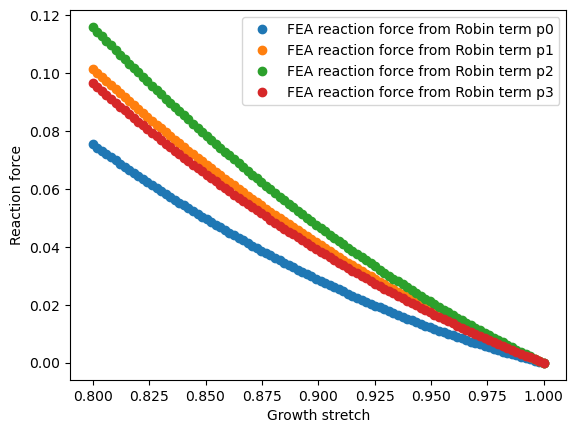

In [19]:
force_x_p0 = np.array(force_x_p0)
force_y_p0 = np.array(force_y_p0)
force_residual_p0 = np.sqrt(force_x_p0**2 + force_y_p0**2)

force_x_p1 = np.array(force_x_p1)
force_y_p1 = np.array(force_y_p1)
force_residual_p1 = np.sqrt(force_x_p1**2 + force_y_p1**2)

force_x_p2 = np.array(force_x_p2)
force_y_p2 = np.array(force_y_p2)
force_residual_p2 = np.sqrt(force_x_p2**2 + force_y_p2**2)

force_x_p3 = np.array(force_x_p3)
force_y_p3 = np.array(force_y_p3)
force_residual_p3 = np.sqrt(force_x_p3**2 + force_y_p3**2)

plt.figure()
# plt.plot(Tlist,force_diff, marker = 's', ls = 'None', label = 'FEA reaction force from differentiation')
plt.plot(Tlist,force_residual_p0, marker = 'o', ls = 'None', label = 'FEA reaction force from Robin term p0')
plt.plot(Tlist,force_residual_p1, marker = 'o', ls = 'None', label = 'FEA reaction force from Robin term p1')
plt.plot(Tlist,force_residual_p2, marker = 'o', ls = 'None', label = 'FEA reaction force from Robin term p2')
plt.plot(Tlist,force_residual_p3, marker = 'o', ls = 'None', label = 'FEA reaction force from Robin term p3')
# plt.plot(Tlist,f_ana, ls = ':', c = 'k', label = 'Analytical')
plt.xlabel('Growth stretch')
plt.ylabel('Reaction force')
# plt.title('Reaction force validation')
plt.legend()

In [20]:
# print(force_diff)
# print(force_residual)
# print(f_ana)